In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import nltk.data
import seaborn as sns
import string
import matplotlib.pyplot as plt
import tensorflow as tf

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize 
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import WordPunctTokenizer 
from nltk.tokenize import TreebankWordTokenizer 
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
train_df.isnull().sum(), test_df.isnull().sum()

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64)

In [4]:
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

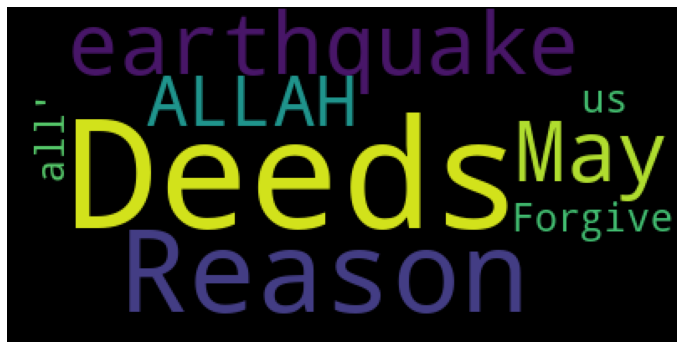

In [5]:
text = train_df.iloc[0:1, [3]].values
text = str(text)

wordcloud = WordCloud().generate(text)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)

plt.axis('off')
plt.show()

In [6]:
def clean_txt(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

train_df['text'] = train_df['text'].apply(clean_txt)
test_df['text'] = test_df['text'].apply(clean_txt)

In [7]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    
    return text.translate(table)

train_df['text'] = train_df['text'].apply(remove_punct)
test_df['text'] = test_df['text'].apply(remove_punct)

In [8]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

train_df['text'] = train_df['text'].apply(remove_emojis)
test_df['text'] = test_df['text'].apply(remove_emojis)

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

normalization = None

vectorizer = 'countvectorizer'

In [10]:
train_df['text'].head(1)

0    Our Deeds are the Reason of this earthquake Ma...
Name: text, dtype: object

In [11]:
train_df['text'].apply(tokenizer.tokenize).head(1)

0    [Our, Deeds, are, the, Reason, of, this, earth...
Name: text, dtype: object

In [12]:
def steam_tokens(tokens):
    stemmer = nltk.stem.PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

def lemmatize_tokens(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

def normalize_tokens(normalization):
    if normalization is not None:
        if normalization == 'stemmer':
            train_df['text'] = train_df['text'].apply(stem_tokens)
            
        elif normalization == 'lemmatizer':
            train_df['text'] = train_df['text'].apply(lemmatize_tokens)
            
normalize_tokens(normalization)

In [13]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [14]:
def remove_stopword(text):
    words = [w for w in text if w not in stopwords.words('english')]
    
    return words

train_df['text'].apply(remove_stopword)
test_df['text'].apply(remove_stopword)

0       [J, u,  , h, p, p, e, n, e,  ,  , e, r, r, b, ...
1       [H, e, r,  , b, u,  , e, r, h, q, u, k, e,  , ...
2       [h, e, r, e,  ,  ,  , f, r, e,  , f, r, e,  , ...
3       [A, p, c, l, p, e,  , l, g, h, n, g,  , S, p, ...
4       [T, p, h, n,  , S, u, e, l, r,  , k, l, l,  , ...
                              ...                        
3258    [E, A, R, T, H, Q, U, A, K, E,  , S, A, F, E, ...
3259    [S, r,  , n,  , R, I,  , w, r, e,  , h, n,  , ...
3260    [G, r, e, e, n,  , L, n, e,  , e, r, l, e, n, ...
3261    [M, E, G,  , u, e,  , H, z, r, u,  , W, e, h, ...
3262    [C, f, C, l, g, r,  , h,  , c, v, e,  ,  , M, ...
Name: text, Length: 3263, dtype: object

In [15]:
def vectorize(vectorizer):
    if vectorizer == 'countvectorizer':
        print('countvectorizer')
        vectorizer = CountVectorizer()
        train_vectors = vectorizer.fit_transform(train_df['text'])
        test_vectors = vectorizer.transform(test_df['text'])
        
    elif vectorizer == 'tfidvectorizer':
        print('tfidvectorizer')
        vectorizer = TfidVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
        train_vectors = vectorizer.fit_transform(train_df['text'])
        test_vectors = vectorizer.transform(test_df['text'])
        
    return train_vectors, test_vectors

train_vectors, test_vectors = vectorize(vectorizer)

countvectorizer


In [16]:
train_vectors

<7613x17798 sparse matrix of type '<class 'numpy.int64'>'
	with 97625 stored elements in Compressed Sparse Row format>

In [17]:
test_vectors

<3263x17798 sparse matrix of type '<class 'numpy.int64'>'
	with 37127 stored elements in Compressed Sparse Row format>

In [18]:
train_vectors.shape, test_vectors.shape

((7613, 17798), (3263, 17798))

In [19]:
output = train_df['target'].values
print(output)

[1 1 1 ... 1 1 1]


In [20]:
train_df.drop('target', inplace=True, axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_vectors, output, test_size=0.25)

In [22]:
X_train = X_train.toarray()

In [23]:
sc = StandardScaler(with_mean=False)

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [24]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

2022-02-18 05:40:19.830226: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
ann.fit(X_train, y_train, batch_size=12, epochs=25)

2022-02-18 05:40:20.372413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
476/476 [==============================] - 2s 3ms/step - loss: 0.6298 - accuracy: 0.6542
Epoch 2/25
476/476 [==============================] - 2s 3ms/step - loss: 0.2671 - accuracy: 0.8925
Epoch 3/25
476/476 [==============================] - 2s 4ms/step - loss: 0.1295 - accuracy: 0.9506
Epoch 4/25
476/476 [==============================] - 2s 4ms/step - loss: 0.0848 - accuracy: 0.9658
Epoch 5/25
476/476 [==============================] - 2s 4ms/step - loss: 0.0637 - accuracy: 0.9739
Epoch 6/25
476/476 [==============================] - 2s 4ms/step - loss: 0.0537 - accuracy: 0.9753
Epoch 7/25
476/476 [==============================] - 2s 3ms/step - loss: 0.0515 - accuracy: 0.9774
Epoch 8/25
476/476 [==============================] - 2s 3ms/step - loss: 0.0479 - accuracy: 0.9779
Epoch 9/25
476/476 [==============================] - 1s 3ms/step - loss: 0.0428 - accuracy: 0.9790
Epoch 10/25
476/476 [==============================] - 1s 3ms/step - loss: 0.0403 - accuracy: 0.9804

In [27]:
pred = ann.predict(X_test)

In [28]:
pred = (pred > 0.5)

In [29]:
print(pred)

[[ True]
 [False]
 [ True]
 ...
 [ True]
 [ True]
 [False]]


In [30]:
cm = confusion_matrix(y_test, pred)

print(cm)
print('\nAccuracy score for confusion matrix: ', accuracy_score(y_test, pred))

[[963 129]
 [308 504]]

Accuracy score for confusion matrix:  0.770483193277311


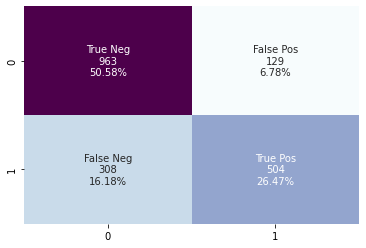

In [31]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='BuPu', cbar=False)

plt.show()

In [32]:
test_vectors = test_vectors.toarray()

In [33]:
validation_pred = ann.predict(test_vectors)

In [34]:
y_pred = np.where(validation_pred > 0.5, 1, 0)

In [35]:
sample_data = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sample_data['id'] = test_df['id']
sample_data['target'] = y_pred

In [36]:
sample_data.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [37]:
sample_data.to_csv('submission.csv', index=False)